<a href="https://colab.research.google.com/github/2mur/stereo-street/blob/main/report_rectification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Part 2**: Image Rectification
using google maps API, from initial coordinates a path is constructed across a street to find unique viewpoints and collect their metadata;

*pano\_id, elevation, panorama coordinates,*

In [ ]:
import requests
import json
import io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#methods for rectification
from PIL import Image
import cv2 as cv
from skimage import io as skio
from skimage.color import rgb2gray
from skimage.feature import SIFT, ORB, match_descriptors, plot_matches
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform

API_KEY = 'insert key'

**PART 1**

*step 1.*

Load dataset with found 'pano_id' from 'stereo-elevation-location.py'

In [ ]:
sdata = pd.read_csv('stereo_dataset.csv', index_col = 0)
sdata.head()

,pano_id,lat,lng,elev,x,y
0,fmnmA6ZrzM38gcPGd6jlJQ,45.495710,-73.582505,57.902134,0.000000,0.000000
1,OgM8drL2r2xhDNR-bQlrxQ,45.495648,-73.582403,57.487469,6.959171,-11.320509
2,thh4EXIvb6-Rv6oKjZekKQ,45.495590,-73.582309,57.088661,13.379291,-21.766271
3,7C_x_Joul6xEg_Mo3qMvFA,45.495528,-73.582209,56.653671,20.209401,-32.878890
4,3ZvByPqo5I-v_H932hy6Ug,45.495468,-73.582111,56.222157,26.878567,-43.734294


*step 2.*

get 2 intersecting view points from neighboring 'pano_id's

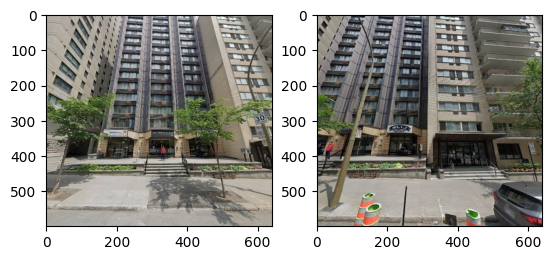

In [ ]:
# Street View API endpoint
def cvt_image_to_array(img):
  return np.array(img)

def get_image_pair_API(i):
  sv_endpoint = 'https://maps.googleapis.com/maps/api/streetview'
  pitch = 15
  fov = 110
  angle=0
  sv_params_left = {
      'size': '640x640',
      'pano':  sdata['pano_id'][i],
      'heading': 43+angle, #60
      'pitch': pitch,
      'fov': fov,
      'key': API_KEY,
  }
  sv_params_right = {
      'size': '640x640',
      'pano':  sdata['pano_id'][i+1],
      'heading': 43+(-angle), #60
      'pitch': pitch,
      'fov': fov,
      'key': API_KEY,
  }

  # Send request to API endpoint and retrieve response
  sv_image_left = requests.get(sv_endpoint, params=sv_params_left)
  sv_image_right = requests.get(sv_endpoint, params=sv_params_right)

  img_left = Image.open(io.BytesIO(sv_image_left.content))
  img_right = Image.open(io.BytesIO(sv_image_right.content))
  img_left.save(f'left_{i}.jpeg'); img_right.save(f'right_{i}.jpeg')

  img_left = cvt_image_to_array(img_left)
  img_right= cvt_image_to_array(img_right)
  w,h,d = img_left.shape

  #crop images to remove google sign, problem with matching
  img_left= img_left[0:w-40,:,:]
  img_right = img_right[0:w-40,:,:]

  fig, ax = plt.subplots(1,2)
  ax[0].imshow(img_left)
  ax[1].imshow(img_right)
  return img_left, img_right

i = 6 #i should be in {0,19}
img_left, img_right = get_image_pair_API(i)

**PART 2**

*step 1.*

Get key-points from a pair of grayscale images (with scikit images SIFT)

In [ ]:
img_leftbw, img_rightbw = map(rgb2gray, (img_left, img_right))

descriptor_extractor = SIFT()
descriptor_extractor.detect_and_extract(img_leftbw)

keypoints_left = descriptor_extractor.keypoints         # (N,) shape
descriptors_left = descriptor_extractor.descriptors     # (N,128) shape

descriptor_extractor.detect_and_extract(img_rightbw)
keypoints_right = descriptor_extractor.keypoints
descriptors_right = descriptor_extractor.descriptors

*step 2.*

Match keypoints between pairs of images (scikit Brute force matcher)

In [ ]:
matches = match_descriptors(descriptors_left, descriptors_right,
                            max_ratio = 0.8, cross_check=True)

print(f'Number of matches: {matches.shape[0]}')
# (K, 2) shape
# keypoints_left[ matches[i,0] ] matches to keypoints_right[  matches[i,1] ]

pts1 = keypoints_left[matches[:, 0]]
pts2 = keypoints_right[matches[:, 1]]

Number of matches: 160


*step 3.*

Filter matching key-points by some distance

(102, 2) (102, 2)


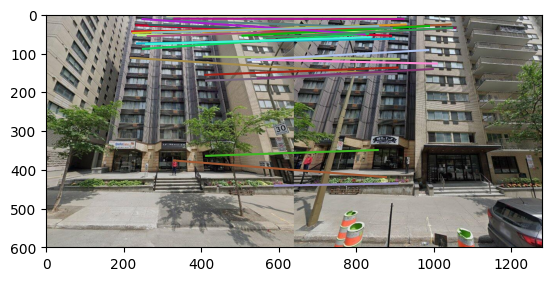

In [ ]:
n = pts1.shape[0]
new_keypoints_left = []; new_keypoints_right = []
newmatches = []
dist_list = []
for i in range(n):
  dist = np.abs(pts1[i,0] - pts2[i,0]) #row distance
  dist_list.append(dist)

  # filter st pixels are more or less on same row axis
  # and some keypoints that should not be seen in right image
  if dist < 50 and pts1[i,1]>50 and pts2[i,1]< 640-50:
    new_keypoints_left.append(pts1[i,:])
    new_keypoints_right.append(pts2[i,:])
    newmatches.append(matches[i,:])

p1 = np.array(new_keypoints_left)
p2 = np.array(new_keypoints_right)
nm = np.array(newmatches)
print(p1.shape,nm.shape )

# Visualize the results.
sample = np.random.choice(nm.shape[0],size=30,replace=False)
fig, ax = plt.subplots()
plot_matches(ax, img_left, img_right, keypoints_left,
             keypoints_right, nm[sample,:], only_matches=True)

*step 4.*

Get fundamental matrix between pairs of images (with ransac in opencv and scikit)

In [ ]:
def F_mat(p, q, method):
  if method == 'scikit':
    # Estimate the epipolar geometry between the left and right image.
    model, _ = ransac((p, q), FundamentalMatrixTransform,
                      min_samples=8, residual_threshold=1,  max_trials=5000)
    F = model.params
    return F
  elif method == 'opencv-ransac':
    F, _ = cv.findFundamentalMat(p, q, cv.FM_RANSAC)
    return F
  elif method == 'opencv-lmeds':
    F, _ = cv.findFundamentalMat(p, q, cv.FM_LMEDS)
    return F
  else:
    return None

F1 = F_mat(p1, p2, method= 'scikit')
F2 = F_mat(p1, p2, method= 'opencv-ransac')
F3 = F_mat(p1, p2, method= 'opencv-lmeds')

F4 = F_mat(pts1, pts2, method= 'scikit')
F5 = F_mat(pts1, pts2, method= 'opencv-ransac')
F6 = F_mat(pts1, pts2, method= 'opencv-lmeds')


In [ ]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img1
        lines - corresponding epilines '''
    imgl = img1.copy()
    imgr = img1.copy()
    r,c,d= img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        imgl = cv.line(imgl, (x0,y0), (x1,y1), color,1)
        imgl = cv.circle(imgl,tuple(pt1),5,color,-1)
        imgr = cv.circle(imgr,tuple(pt2),5,color,-1)
    return imgl,imgr

Fl = [F1,F2,F3,F4,F5,F6]
p = p1; q = p2

h,w = img_leftbw.shape
for i in range(6):
  F = Fl[i]
  # drawing lines on left image
  lines1 = cv.computeCorrespondEpilines(q.reshape(-1,1,2), 2, F)
  lines1 = lines1.reshape(-1,3)
  img_left1,img_left2 = drawlines(img_left,img_right,lines1, p,q)

  # drawing lines on right image
  lines2 = cv.computeCorrespondEpilines(p.reshape(-1,1,2), 1, F)
  lines2 = lines2.reshape(-1,3)
  img_right1,img_right2 = drawlines(img_right,img_left, lines2,q,p)

  fig, ax = plt.subplots(1,2)
  ax[0].set_title(f'F_{i+1}: Right epilines as \n seen from left image')
  ax[0].imshow(img_left1)
  ax[1].set_title(f'F_{i+1}: Left epilines as \n seen from right image')
  ax[1].imshow(img_right1)
  #ax[2].imshow(img_left2)
  #ax[3].imshow(img_right2)


*step 4.*

Reproject images (with opencv)

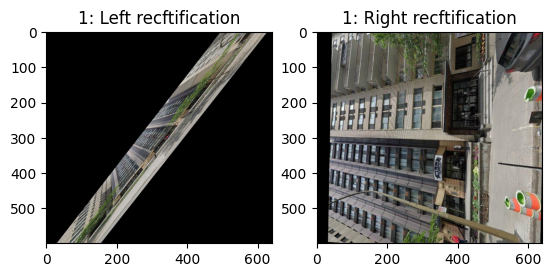

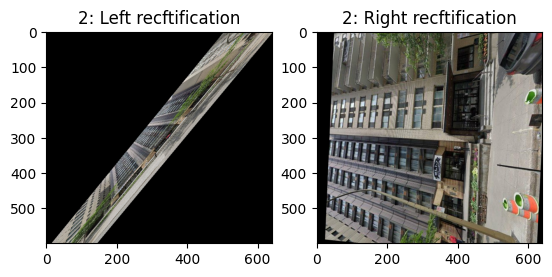

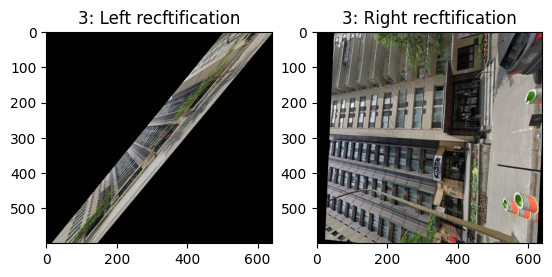

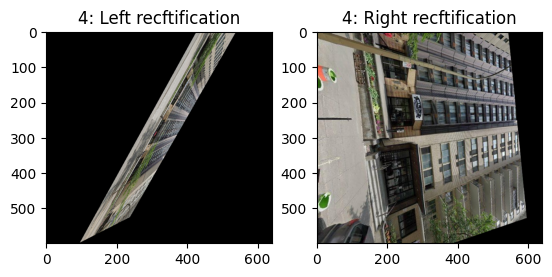

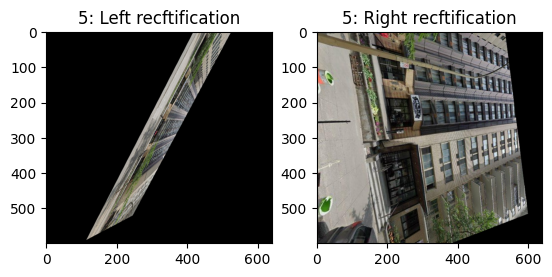

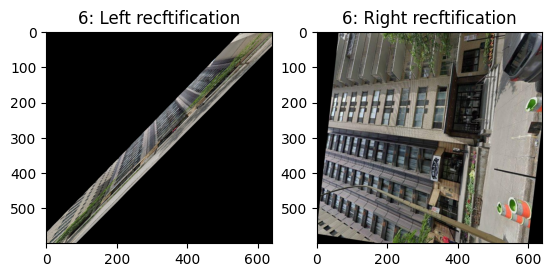

In [ ]:
h,w = img_leftbw.shape
for i in range(6):
  F = Fl[i]
  _,H1,H2 = cv.stereoRectifyUncalibrated(img_left,img_right, F, (w,h))

  s = 1
  left_rectified = cv.warpPerspective(img_left, H1, (s*w,s*h))
  right_rectified = cv.warpPerspective(img_right, H2, (s*w,s*h))

  # Visualize the results.
  fig, ax = plt.subplots(1,2)
  plt.title(f"Rectified images {i+1}")
  ax[0].set_title(f'{i+1}: Left recftification')
  ax[0].imshow(left_rectified)
  ax[1].set_title(f'{i+1}: Right recftification')
  ax[1].imshow(right_rectified)
